In [1]:
from __future__ import print_function
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
from collections import deque, namedtuple
import datetime
from matplotlib import pyplot as plt
%matplotlib inline


if "../" not in sys.path:
  sys.path.append("../")

from side_grids_camp.agents.dqn import StateProcessor, Estimator, DQNAgent
from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game

## TESTS

/home/langust/progz/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Sokoban in grey-scale:
[[152 152 152 152 152 152]
 [152 219 134 152 152 152]
 [152 219  78 219 219 152]
 [152 152 219 219 219 152]
 [152 152 152 219 129 152]
 [152 152 152 152 152 152]]


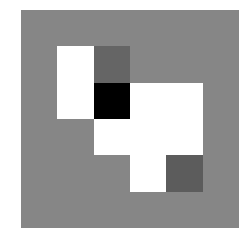

[[ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593616  0.08785374  0.01562183 -0.        ]
 [ 0.05593615  0.08785375  0.01562183 -0.        ]
 [ 0.05593615  0.08785375  0.01562183 -0.        ]]
[ 0.08785374  0.08785374  0.08785374  0.08785374  0.08785374  0.08785374
  0.08785375  0.08785375]
57.1253


In [2]:
#
# Test preprocessing and estimator
#

global_step = tf.Variable(0, name="global_step", trainable=False)


env = sokoban_game(level=0)
actions_num = env.action_spec().maximum + 1
world_shape = env.observation_spec()['board'].shape
frames_state = 2
batch_size = 8
e = Estimator(actions_num, world_shape[0], world_shape[1], scope="test")
sp = StateProcessor(world_shape[0], world_shape[1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    time_step = env.reset()
    
    frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
    observation_p = sp.process(sess, frame)

    print("Sokoban in grey-scale:")
    print(observation_p)
    
    plt.figure()
    plt.imshow(observation_p/255.0, cmap='gray')
    plt.axis('off')
    plt.show()
    
    observation = np.stack([observation_p] * frames_state, axis=2)
    observations = np.array([observation] * batch_size)
    
    # Test Prediction
    pred = e.predict(sess, observations)
    print(pred)
    print(pred.max(axis=1))

    # Test training step
    y = np.array([10.0, 4.0] * (batch_size/2))
    a = np.array([1, 3] * (batch_size/2))
    print(e.update(sess, observations, a, y))


In [ ]:
## Some tests:

# TimeStep inherits from:
#   collections.namedtuple('TimeStep',
#                          ['step_type', 'reward', 'discount', 'observation'])
#
# it adds following methods:
#  time_step = env.reset()
#  time_step.first()
#  time_step.mid()
#  time_step.last()

time_step = env.reset()
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("Let's act..")
time_step = env.step(2)
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("RGB image dims: {}".format(time_step.observation['RGB'].shape))
print("Plot from rgb:")
frame = np.moveaxis(time_step.observation['RGB'],0,-1)
plt.figure()
plt.imshow(frame)
plt.axis('off')
plt.show()

print("Plot board:")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

## TRAIN

In [2]:
EpisodeStats = namedtuple("EpisodeStats", ["episode_lengths", "episode_rewards"])

In [ ]:
print("Start training side effects sokoban.")
env = sokoban_game(level=0)
actions_num = env.action_spec().maximum + 1
world_shape = env.observation_spec()['board'].shape
frames_state = 2
batch_size = 32

start_time = datetime.datetime.now()
num_episodes = 50  # 5000
stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
                     episode_rewards=np.zeros(num_episodes))

tf.reset_default_graph()
with tf.Session() as sess:
    agent = DQNAgent(sess,
                 world_shape,
                 actions_num,
                 env,
                 frames_state=frames_state,
                 experiment_dir=None,
                 replay_memory_size=10000,  # 10000
                 replay_memory_init_size=500,  # 3000
                 update_target_estimator_every=250,  # 500
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=50000,
                 batch_size=batch_size)

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        agent.save()

        ret = 0
        time_step = env.reset()  # for the description of timestep see ai_safety_gridworlds.environments.shared.rl.environment
        for t in itertools.count():
            action = agent.act(time_step.observation)
            time_step = env.step(action)
            loss = agent.learn(time_step, action)

            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                        t, agent.total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            ret += time_step.reward
            if time_step.last():
                break
        stats.episode_lengths[i_episode] = t
        stats.episode_rewards[i_episode] = ret
        if i_episode % 25 == 0:
            print("\nEpisode return: {}, and performance: {}.".format(ret, env.get_last_performance()))


elapsed = datetime.datetime.now() - start_time
print("Return: {}, elasped: {}.".format(ret, elapsed))
print("Traning finished.")